In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
x = np.fromfile('CELESTA_2022-07-24T19_25_49.sigmf-data', 'int16')
x = x[::2] + 1j * x[1::2]
N = 4000
fs = 40e3
y = np.average(x[:x.size//N*N].reshape(-1, N), axis=1)
ty = np.arange(y.size) * N/fs

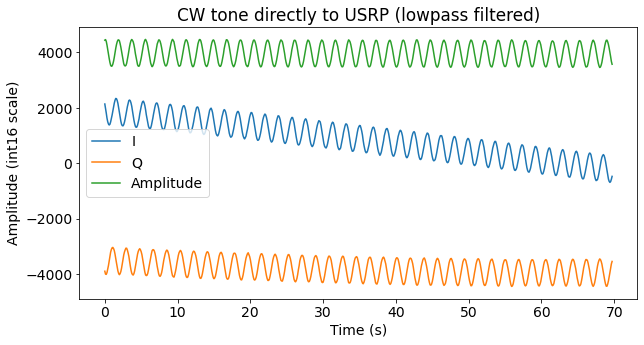

In [3]:
plt.plot(ty, y.real)
plt.plot(ty, y.imag)
plt.plot(ty, np.abs(y))
plt.legend(['I', 'Q', 'Amplitude'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (int16 scale)')
plt.title('CW tone directly to USRP (lowpass filtered)');

In [4]:
pwr = np.average(np.abs(y)**2)
pwr_usrp = pwr

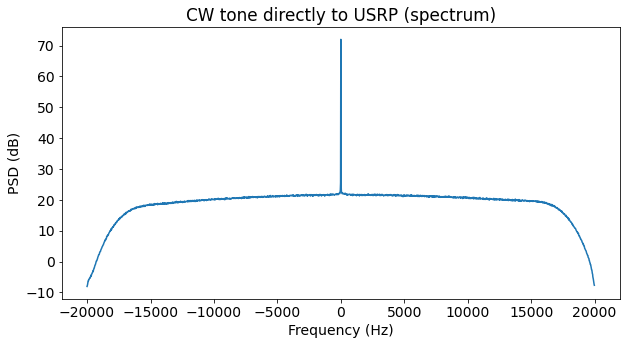

In [5]:
NFFT = 2048
f = np.fft.fftshift(np.average(np.abs(
    np.fft.fft(x[:x.size//NFFT*NFFT].reshape(-1, NFFT),
               norm='forward'))**2, axis=0))
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))
plt.plot(faxis, 10*np.log10(f))
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title('CW tone directly to USRP (spectrum)');

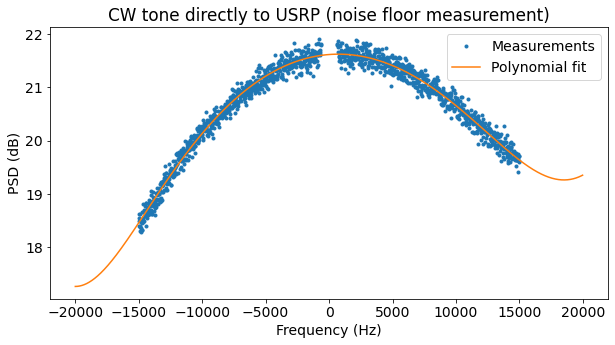

In [6]:
sel = np.concatenate((
    np.arange(NFFT//8, NFFT//2-32),
    np.arange(NFFT//2+32+1, 7*NFFT//8+1)
))
p = np.polyfit(np.arange(NFFT)[sel], f[sel], 4)
fp = np.polyval(p, np.arange(NFFT))
plt.plot(faxis[np.arange(NFFT)[sel]], 10*np.log10(f[sel]), '.')
plt.plot(faxis, 10*np.log10(fp));
noise_per_bin = np.polyval(p, NFFT//2)
plt.legend(['Measurements', 'Polynomial fit'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title('CW tone directly to USRP (noise floor measurement)');

In [7]:
fs = 40e3
n0 = noise_per_bin * NFFT / fs
10*np.log10(n0)

8.709783064528803

In [8]:
cn0 = pwr / n0
10*np.log10(cn0)

63.28197020260458

In [9]:
x = np.fromfile('CELESTA_2022-07-24T19_29_02.sigmf-data', 'int16')
x = x[::2] + 1j * x[1::2]
y = np.average(x[:x.size//N*N].reshape(-1, N), axis=1)
ty = np.arange(y.size) * N/fs

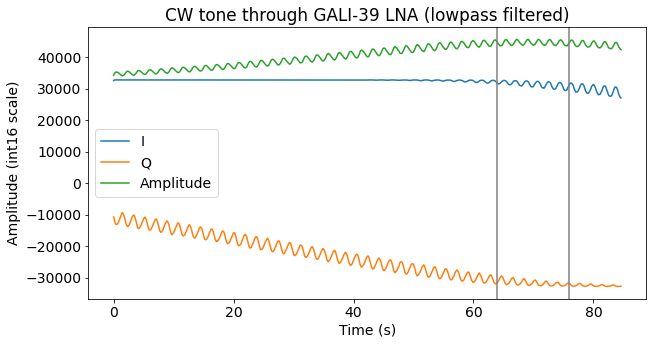

In [10]:
plt.plot(ty, y.real)
plt.plot(ty, y.imag)
plt.plot(ty, np.abs(y));
plt.axvline(x=ty[640], color='grey')
plt.axvline(x=ty[760], color='grey')
plt.legend(['I', 'Q', 'Amplitude'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (int16 scale)')
plt.title('CW tone through GALI-39 LNA (lowpass filtered)');

In [11]:
pwr = np.average(np.abs(y[640:760]**2))
pwr_lna = pwr

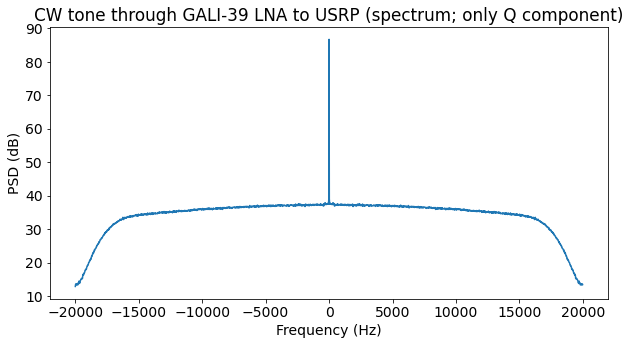

In [12]:
NFFT = 2048
# use the imaginary part of noise, since it doesn't have clipping
f = np.fft.fftshift(np.average(np.abs(
    np.fft.fft(x.imag[:600*N//NFFT*NFFT].reshape(-1, NFFT),
               norm='forward'))**2, axis=0))
plt.plot(faxis, 10*np.log10(f))
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title('CW tone through GALI-39 LNA to USRP (spectrum; only Q component)');

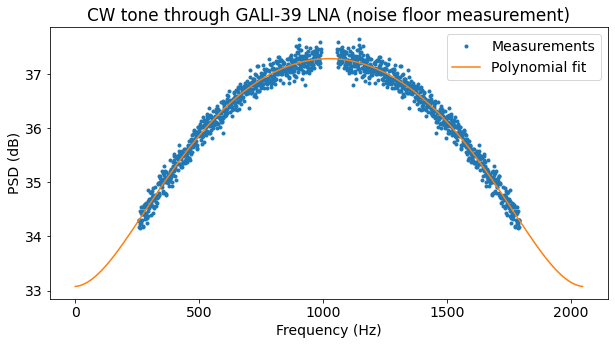

In [13]:
sel = np.concatenate((
    np.arange(NFFT//8, NFFT//2-32),
    np.arange(NFFT//2+32+1, 7*NFFT//8+1)
))
p = np.polyfit(np.arange(NFFT)[sel], f[sel], 4)
fp = np.polyval(p, np.arange(NFFT))
plt.plot(np.arange(NFFT)[sel], 10*np.log10(f[sel]), '.')
plt.plot(np.arange(NFFT), 10*np.log10(fp));
noise_per_bin = np.polyval(p, NFFT//2)
plt.legend(['Measurements', 'Polynomial fit'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB)')
plt.title('CW tone through GALI-39 LNA (noise floor measurement)');

In [14]:
fs = 40e3
# The factor 2 accounts for the fact that we've only measured x.imag
n0 = 2 * noise_per_bin * NFFT / fs
10*np.log10(n0)

27.384160254244044

In [15]:
cn0 = pwr / n0
10*np.log10(cn0)

65.59232588089377

In [16]:
cn0_lna = 65.6
NF_lna = 2.4
n0_lna_dbm = 10*np.log10(10**(NF_lna/10) + 1) - 174
pwr_tone_dbm = cn0_lna + n0_lna_dbm
pwr_tone_dbm

-104.02598149380029

In [17]:
cn0_usrp = 63.3
n0_usrp = pwr_tone_dbm - cn0_usrp
NF_usrp = 10*np.log10(10**((n0_usrp + 174)/10) - 1)
NF_usrp

5.622277605151361

In [18]:
lna_gain = 10*np.log10(pwr_lna) - 10*np.log10(pwr_usrp)
lna_gain

20.984732868004414

In [19]:
transfer_to_dbm = pwr_tone_dbm - 10*np.log10(pwr_usrp)
transfer_to_dbm

-176.01773476093368